In [33]:
import tensorflow as tf
import keras
import os

In [34]:
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [35]:
PATH = './images/train'
CLASS_NAMES = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
BATCH_SIZE = 32
print(os.listdir(PATH))

['no', 'thankyou', 'yes']


Preprocessing Images

In [36]:
# Define input directory
input_dir_train = 'images/train'
input_dir_test = 'images/test'

# Define batch size and image size
batch_size = 32
image_size = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    input_dir_train,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    input_dir_test,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,    
)

print("Datasets created successfully.")

Found 72 files belonging to 3 classes.
Found 18 files belonging to 3 classes.
Datasets created successfully.


In [37]:
os.listdir(input_dir_test)

['no', 'thankyou', 'yes']

In [38]:
for images, labels in train_dataset.take(1):
    print(labels)

tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(32, 3), dtype=float32)


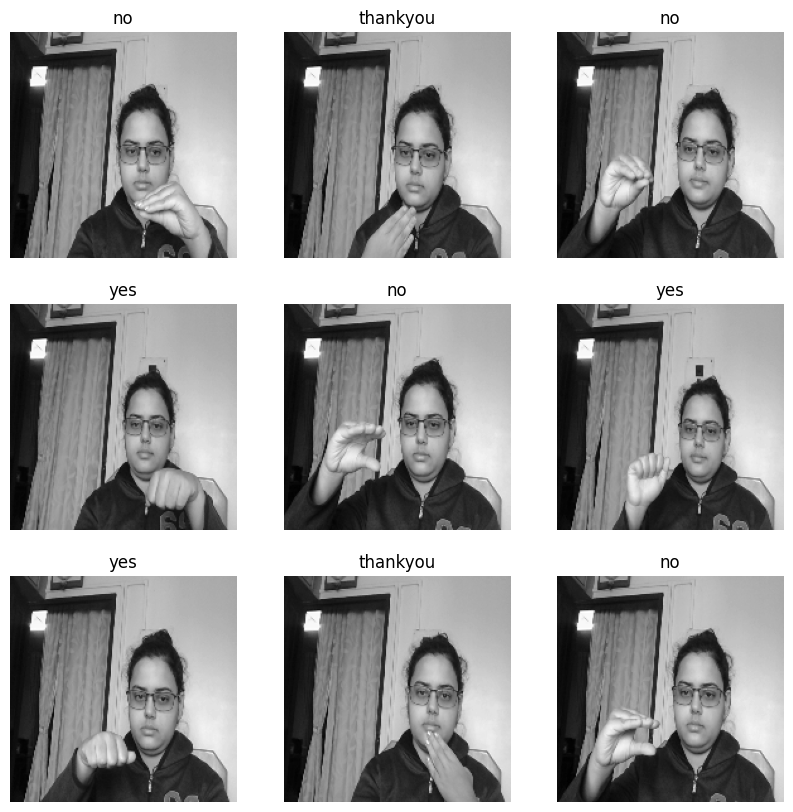

In [39]:
import matplotlib.pyplot as plt

class_names = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Assuming you want to visualize from the train_dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray')  # Squeeze to remove the single-channel dimension
        plt.title(class_names[tf.argmax(labels[i]).numpy()])  # Assuming labels are one-hot encoded
        plt.axis("off")
plt.show()


Model Creation


In [44]:
# Define input shape
image_height, image_width = 180, 180
num_classes = 3

# Define the CNN model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 1)),
    layers.Conv2D(16, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [45]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,968,131 (15.14 MB)

 Trainable params: 3,968,131 (15.14 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Fit the model 
epochs = 10
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=epochs,
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9488 - loss: 0.2754
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9332 - loss: 0.2737
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9379 - loss: 0.2780
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8728 - loss: 0.3226
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9379 - loss: 0.2664
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8416 - loss: 0.2695
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9145 - loss: 0.2692
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9497 - loss: 0.1984
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9518 - loss: 0.2079
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9371 - loss: 0.2261


In [51]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print("Test Accuracy:", test_accuracy)

print("Model trained and evaluated successfully.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step - accuracy: 0.8333 - loss: 0.4883
Test accuracy: 0.8333333134651184
Test Accuracy: 0.8333333134651184
Model trained and evaluated successfully.


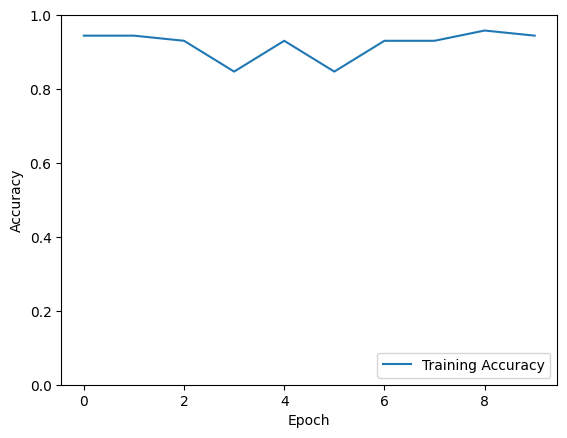

In [52]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

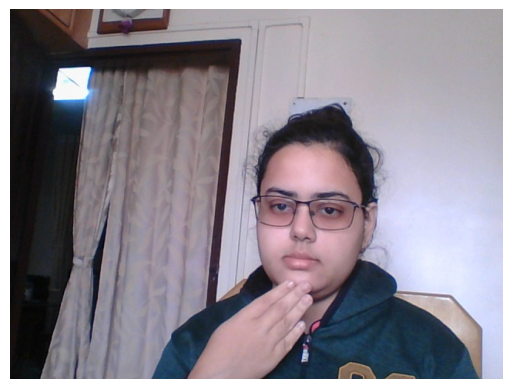

In [53]:
import numpy as np
import matplotlib.pyplot as plt

test_image_path = 'images/test/thankyou/thankyou.5815b00a-bb53-11ee-9b05-2cdb079ec43c.jpg'
# Load the test image
test_image = plt.imread(test_image_path)

# Display the test image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [54]:
# Resize the test image if necessary (assuming 'image_size' is the desired size)
image_size=[180, 180]
if test_image.shape[:2] != image_size:
    test_image = tf.image.resize(test_image, image_size)
# Convert the resized image to grayscale
test_image_gray = tf.image.rgb_to_grayscale(test_image)
test_image_gray = tf.expand_dims(test_image_gray, axis=0)  # Add batch dimension


In [55]:
# Predict the class of the test image using the trained model
predictions = model.predict(test_image_gray)

# Convert predictions to numpy array
predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


In [56]:
predictions

array([[2.7223150e-04, 9.9960786e-01, 1.1992765e-04]], dtype=float32)

In [57]:
# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

# Output the predicted class label
class_names = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
predicted_class_label = class_names[predicted_class_index]
print("Predicted class is:", predicted_class_label)

Predicted class index: 1
Predicted class is: thankyou


In [58]:
model.save('cnn_Ananki_acc94_testac83_gray.h5')

In [59]:
model.save('cnn_Ananki_acc94_testac83_gray.keras')